In [1]:
from ada_csl_wrc.evaluation import evaluate
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import train_test_split

from ada_csl_wrc.models import CostSensitiveDecisionTreeClassifier

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import mutual_info_classif
from ada_csl_wrc.models import ConstrainedCSDecisionTree
from ada_csl_wrc.models import Constrained
from sklearn.model_selection import train_test_split
from ada_csl_wrc.utils import prediction_up_to_constraint
from ada_csl_wrc.utils import prepare_for_cost_cle
from ada_csl_wrc.utils import filter_only_worst_features
from ada_csl_wrc.utils import find_effective_threshold
import json
import pickle
from copy import deepcopy


loaded ada_csl_wrc.utils


### Hyperparameters of the experiment


In [2]:
COST_FALSE_NEGATIVE = 10
COST_FALSE_POSITIVE = 1
t = COST_FALSE_POSITIVE/(COST_FALSE_POSITIVE+COST_FALSE_NEGATIVE)
COST_MATRIX = np.array([[0, COST_FALSE_POSITIVE], [COST_FALSE_NEGATIVE, 0]])
FEATURES_RATIO = 1.0

In [3]:
COST_MATRIX

array([[ 0,  1],
       [10,  0]])

### Data-specific code

This part includes some data-specific code. It is not included in the final model. <br>
The X and the y are the dataframes that are used for training and testing.


In [4]:
cs_best_params = json.load(open("./config/cost_sensitive_best_params.json", "r")) #hard-coded in a json file
#dt_best_params = find_best_params(dt_param_grid, X, y) #find it using grid search
dt_best_params = {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 20}

In [5]:
df = pd.read_csv('./data/feature_dataset_500.csv')#, index_col='credentialset_id')


In [6]:
df.shape

(30000, 26)

In [7]:
df.head()

,credentialset_id,prediction_date,n_updates_30d,mean_time_30d,max_time_30d,min_time_30d,n_updates_60d,mean_time_60d,max_time_60d,min_time_60d,...,max_time_120d,min_time_120d,provider_n_updates,provider_n_updates_weekday,n_updates_weekday,n_successful_crawls,n_unsuccessful_crawls,is_last_crawl_succed,n_days_since_last_crawl,target
0,0000349e-0a0f-3373-a4f1-05bce8b528b3,2023-06-02,0.260870,4.200000,8,2,0.301887,3.0,8,1,...,14,1,0.434547,0.576039,0.000000,3.0,3.0,0.0,1.0,0.0
1,0000349e-0a0f-3373-a4f1-05bce8b528b3,2023-06-03,0.217391,4.750000,8,3,0.301887,3.0,8,1,...,14,1,0.434547,0.000442,0.000000,3.0,4.0,0.0,1.0,0.0
2,0000349e-0a0f-3373-a4f1-05bce8b528b3,2023-06-04,0.217391,4.750000,8,3,0.301887,3.0,8,1,...,14,1,0.434547,0.353227,0.000000,2.0,5.0,0.0,1.0,0.0
3,0000349e-0a0f-3373-a4f1-05bce8b528b3,2023-06-05,0.173913,5.333333,8,3,0.301887,3.0,8,1,...,14,1,0.434547,0.433245,0.038462,2.0,5.0,0.0,1.0,0.0
4,0000349e-0a0f-3373-a4f1-05bce8b528b3,2023-06-06,0.173913,5.333333,8,3,0.301887,3.0,8,1,...,14,1,0.434547,0.603678,0.000000,2.0,5.0,0.0,1.0,0.0


In [8]:
provider_ids = pickle.load(open("data\provider_ids.pickle", "rb"))

In [9]:
df_with_provider = df.join(provider_ids, on='credentialset_id')
df_with_provider.head()

,credentialset_id,prediction_date,n_updates_30d,mean_time_30d,max_time_30d,min_time_30d,n_updates_60d,mean_time_60d,max_time_60d,min_time_60d,...,min_time_120d,provider_n_updates,provider_n_updates_weekday,n_updates_weekday,n_successful_crawls,n_unsuccessful_crawls,is_last_crawl_succed,n_days_since_last_crawl,target,provider_id
0,0000349e-0a0f-3373-a4f1-05bce8b528b3,2023-06-02,0.260870,4.200000,8,2,0.301887,3.0,8,1,...,1,0.434547,0.576039,0.000000,3.0,3.0,0.0,1.0,0.0,867c4a38-0d75-46ff-a4c2-f44cb63be2c9
1,0000349e-0a0f-3373-a4f1-05bce8b528b3,2023-06-03,0.217391,4.750000,8,3,0.301887,3.0,8,1,...,1,0.434547,0.000442,0.000000,3.0,4.0,0.0,1.0,0.0,867c4a38-0d75-46ff-a4c2-f44cb63be2c9
2,0000349e-0a0f-3373-a4f1-05bce8b528b3,2023-06-04,0.217391,4.750000,8,3,0.301887,3.0,8,1,...,1,0.434547,0.353227,0.000000,2.0,5.0,0.0,1.0,0.0,867c4a38-0d75-46ff-a4c2-f44cb63be2c9
3,0000349e-0a0f-3373-a4f1-05bce8b528b3,2023-06-05,0.173913,5.333333,8,3,0.301887,3.0,8,1,...,1,0.434547,0.433245,0.038462,2.0,5.0,0.0,1.0,0.0,867c4a38-0d75-46ff-a4c2-f44cb63be2c9
4,0000349e-0a0f-3373-a4f1-05bce8b528b3,2023-06-06,0.173913,5.333333,8,3,0.301887,3.0,8,1,...,1,0.434547,0.603678,0.000000,2.0,5.0,0.0,1.0,0.0,867c4a38-0d75-46ff-a4c2-f44cb63be2c9


In [10]:
df_with_provider['provider_id'].value_counts()[:4]

provider_id
867c4a38-0d75-46ff-a4c2-f44cb63be2c9    5220
a12f6956-9aca-4550-8caa-2e2f9532674c    1740
02531004-4599-4177-9d7d-00bc85a200c6    1680
856f211d-c66e-4db7-b910-7419900a70e1    1380
Name: count, dtype: int64

In [11]:
providers_list = df_with_provider['provider_id'].value_counts()[:4].index

In [12]:
def predict_constrained_cs(X_train, X_test, y_train, y_test, constraint, cs_best_params):
    #initialize the threshold
    threshold = 0.0
    effective_threshold = 1.0
    lower_bound = 0.0
    upper_bound = 1000.0 #Should be a big number, I don't know what is big enough
    cfp = 0
    cfn = 10
    results_dict = {}
    cm_dict = {}
    i = 0
    
    #High CFP increase the threshold and vice versa
    while (effective_threshold > threshold) or (abs(upper_bound - lower_bound) > 1.0):
    #for i in range(50):
    
        print(
            f"Threshold: {threshold:.2f}", 
            f"Effective Threshold: {effective_threshold:.2f}", 
            f"Cost False Positive: {cfp:.2f}", 
            f"Lower Bound: {lower_bound:.2f}",
            f"Upper Bound: {upper_bound:.2f}",
            sep = " ", end="\r", flush=True)
        
        threshold = cfp/(cfp+cfn)
        cost_matrix = np.array([[0, cfp], 
                                [cfn, 0]])
        model_i = CostSensitiveDecisionTreeClassifier() #The base object, we will train it.
        model_i.set_params(**cs_best_params)
        model_i.fit(X_train.to_numpy(), y_train.to_numpy(), cost_mat = prepare_for_cost_cle(len(X_train), cost_matrix)) 
        y_pred_proba = model_i.predict_proba(X_test.to_numpy())[:, 1]
        effective_threshold = find_effective_threshold(y_pred_proba, constraint, threshold) 
        y_pred_constrained = prediction_up_to_constraint(y_pred_proba, constraint)
        y_pred = model_i.predict(X_test.to_numpy())
        # results_dict[i] =  evaluate(y_test, y_pred, COST_MATRIX)
        # cm_dict[i] = confusion_matrix(y_test, y_pred)
        results_dict[i] = {'constrained': evaluate(y_test, y_pred_constrained, COST_MATRIX), 'unconstrained': evaluate(y_test, y_pred, COST_MATRIX)}
        cm_dict[i] = {'constrained': confusion_matrix(y_test, y_pred_constrained), 'unconstrained': confusion_matrix(y_test, y_pred)}
    
        #The binary search, if we overshot, we need to decrease cfp
        if effective_threshold <= threshold: #It means we have found a good cfp, but might not be the best
            upper_bound = cfp
            cfp = (cfp+lower_bound)/2
                  
        else: #We undershot, we need to increase cfp
            lower_bound = cfp
            cfp = (cfp+upper_bound)/2
        i+=1
        
    best_model_ = deepcopy(model_i) #This one is already trained.
    cfp_ = cfp
    threshold_ = threshold
    
    print("\nDONE")
    print(f"Threshold: {threshold:.2f}")
    print(f"Effective threshold: {effective_threshold:.2f}")
    print("Current cfp: ", cfp)
    print("Lower bound: ", lower_bound)
    print("Upper bound: ", upper_bound)
    return best_model_, results_dict, cm_dict

In [13]:
def predict_dt(X_train, X_test, y_train, y_test, constraint, dt_best_params):
    results_dict, cm_dict = {}, {}
    dt_model = DecisionTreeClassifier(**dt_best_params)
    dt_model.fit(X_train, y_train)
    y_pred = dt_model.predict(X_test)
    y_pred_proba = dt_model.predict_proba(X_test)[:, 1]
    y_pred_constrained = prediction_up_to_constraint(y_pred_proba, constraint)
    results_dict = {'constrained': evaluate(y_test, y_pred_constrained, COST_MATRIX), 'unconstrained': evaluate(y_test, y_pred, COST_MATRIX)}
    cm_dict= {'constrained': confusion_matrix(y_test, y_pred_constrained), 'unconstrained': confusion_matrix(y_test, y_pred)}
    return dt_model, results_dict, cm_dict

In [14]:
def predict_constrained_cs_old(X_train, X_test, y_train, y_test, constraint, cs_best_params):
    #initialize the threshold
    effective_threshold = 1.0
    cfp = 0
    cfn = 10
    results_dict = {}
    cm_dict = {}

    for i in range(50):
        cfp += 1
        threshold = cfp/(cfp+cfn)
        print(
            f"Threshold: {threshold:.2f}", 
            f"Effective Threshold: {effective_threshold:.2f}", 
            f"Cost False Positive: {cfp:.2f}", 
            sep = " ", end="\r", flush=True)
        
        
        cost_matrix = np.array([[0, cfp], 
                                [cfn, 0]])
        model_i = CostSensitiveDecisionTreeClassifier() #The base object, we will train it.
        model_i.set_params(**cs_best_params)
        model_i.fit(X_train.to_numpy(), y_train.to_numpy(), cost_mat = prepare_for_cost_cle(len(X_train), cost_matrix)) 
        y_pred = model_i.predict(X_test.to_numpy())
        y_pred_proba = model_i.predict_proba(X_test.to_numpy())[:, 1]
        effective_threshold = find_effective_threshold(y_pred_proba, constraint, threshold) 
        y_pred_constrained = prediction_up_to_constraint(y_pred_proba, constraint)
        results_dict[i] = {'constrained': evaluate(y_test, y_pred_constrained, COST_MATRIX), 'unconstrained': evaluate(y_test, y_pred, COST_MATRIX)}
        cm_dict[i] = {'constrained': confusion_matrix(y_test, y_pred_constrained), 'unconstrained': confusion_matrix(y_test, y_pred)}
        
        #The binary search, if we overshot, we need to decrease cfp
        if effective_threshold <= threshold: 
            break

        
    best_model_ = deepcopy(model_i) #This one is already trained.
    cfp_ = cfp
    threshold_ = threshold
    
    print("\nDONE")
    print(f"Threshold: {threshold:.2f}")
    print(f"Effective threshold: {effective_threshold:.2f}")
    print("Current cfp: ", cfp)
    return best_model_, results_dict, cm_dict

In [15]:
def predict_cw_dt(X_train, X_test, y_train, y_test, constraint, dt_best_params):
    #initialize the threshold
    effective_threshold = 1.0
    cfp = 0
    cfn = 1
    results_dict = {}
    cm_dict = {}

    for i in range(100):
        cfp += 0.1
        threshold = cfp/(cfp+cfn)
        print(
            f"Threshold: {threshold:.2f}", 
            f"Effective Threshold: {effective_threshold:.2f}", 
            f"Cost False Positive: {cfp:.2f}", 
            sep = " ", end="\r", flush=True)
        
        
        cost_matrix = np.array([[0, cfp], 
                                [cfn, 0]])
        model_i = DecisionTreeClassifier(class_weight={0:cfp, 1:cfn}) #The base object, we will train it.
        model_i.set_params(**dt_best_params)
        model_i.fit(X_train, y_train) 
        y_pred = model_i.predict(X_test)
        y_pred_proba = model_i.predict_proba(X_test)[:, 1]
        effective_threshold = find_effective_threshold(y_pred_proba, constraint, threshold) 
        y_pred_constrained = prediction_up_to_constraint(y_pred_proba, constraint)
        results_dict[i] = {'constrained': evaluate(y_test, y_pred_constrained, COST_MATRIX), 'unconstrained': evaluate(y_test, y_pred, COST_MATRIX)}
        cm_dict[i] = {'constrained': confusion_matrix(y_test, y_pred_constrained), 'unconstrained': confusion_matrix(y_test, y_pred)}
        
        #The binary search, if we overshot, we need to decrease cfp
        # if effective_threshold <= threshold: 
        #     break

        
    best_model_ = deepcopy(model_i) #This one is already trained.
    cfp_ = cfp
    threshold_ = threshold
    
    print("\nDONE")
    print(f"Threshold: {threshold:.2f}")
    print(f"Effective threshold: {effective_threshold:.2f}")
    print("Current cfp: ", cfp)
    return best_model_, results_dict, cm_dict

In [16]:
def calc_max_acc(n_pos, const, n_cred):
    if n_pos > const:
        return (const + n_cred - n_pos)/n_cred
    else: 
        return (n_pos + n_cred - const)/n_cred 
    

In [17]:
def create_groupby_df(mask_dates, mask_test_provider, min_const=0.9, max_const=0.7):
    groupby_df = pd.DataFrame(df[mask_dates & mask_test_provider].groupby('prediction_date')['target'].sum())
    n_cred = (df[mask_dates & mask_test_provider].shape[0]/10)
    groupby_df = groupby_df.rename(columns={'target': 'n_positive'})
    groupby_df['%positive'] = groupby_df['n_positive']/n_cred
    constraints_list = []
    constraints_list.append(np.round(groupby_df['n_positive'].min()*min_const)) # the constraint is about 90 percent from the minimum positives in the test dates - can be changed
    constraints_list.append(np.round(groupby_df['n_positive'].max()*max_const))
    for i, constraint in enumerate(constraints_list):
        groupby_df[f'max_acc_constraint_{i}'] = groupby_df['n_positive'].apply(calc_max_acc, const=constraint, n_cred=n_cred) 
        groupby_df[f'%constraint_{i}'] = constraint/groupby_df['n_positive']
    return groupby_df, constraints_list, n_cred

In [18]:
test_dates = df['prediction_date'].unique()[-10:]
mask_dates = df['prediction_date'].isin(test_dates)

In [67]:
provider_dict = {}
for provider in providers_list:
    print(provider)
    cs_provider_dict, dt_provider_dict = {}, {}
    mask_test_provider = df_with_provider['provider_id'] == provider
    provider_groupby_df, constraints_list, n_cred = create_groupby_df(mask_dates, mask_test_provider)

    for i, date in enumerate(test_dates):
        print(date)
        mask_train_dates = df['prediction_date'].isin(df['prediction_date'].unique()[i:-10+i])
        mask_test_date = df['prediction_date'] == date
        X_train = df[mask_train_dates].drop(labels=['credentialset_id', 'prediction_date', 'target'], axis=1)
        X_test = df[mask_test_provider & mask_test_date].drop(labels=['credentialset_id', 'prediction_date', 'target'], axis=1)
        y_train = df[mask_train_dates]['target']
        y_test = df[mask_test_date & mask_test_provider]['target']
        cs_constraint_dict, dt_constraint_dict = {}, {}
        for const in constraints_list:
            constraint = const/len(y_test)
            cs_best_model_, cs_results_dict, cs_cm_dict = predict_constrained_cs_old(X_train, X_test, y_train, y_test, constraint, cs_best_params)
            dt_model, dt_results_dict, dt_cm = predict_dt(X_train, X_test, y_train, y_test, constraint, dt_best_params)
            cs_constraint_dict[const] = {'best_model_': cs_best_model_, 'results_dict': cs_results_dict, 'cm_dict': cs_cm_dict}
            dt_constraint_dict[const] = {'best_model_': dt_model, 'results_dict': dt_results_dict, 'cm_dict': dt_cm}
        cs_provider_dict[date] =  cs_constraint_dict
        dt_provider_dict[date] = dt_constraint_dict
    
    provider_dict[provider] = {'cs_dict': cs_provider_dict, 'dt_dict': dt_provider_dict, 'constraints_list': constraints_list, 'n_cred': n_cred, 'groupby_df': provider_groupby_df}


867c4a38-0d75-46ff-a4c2-f44cb63be2c9
2023-07-22
Threshold: 0.47 Effective Threshold: 0.51 Cost False Positive: 9.00
DONE
Threshold: 0.47
Effective threshold: 0.47
Current cfp:  9
Threshold: 0.41 Effective Threshold: 0.70 Cost False Positive: 7.00
DONE
Threshold: 0.41
Effective threshold: 0.41
Current cfp:  7
2023-07-23
Threshold: 0.76 Effective Threshold: 0.88 Cost False Positive: 31.00
DONE
Threshold: 0.76
Effective threshold: 0.76
Current cfp:  31
Threshold: 0.68 Effective Threshold: 0.83 Cost False Positive: 21.00
DONE
Threshold: 0.68
Effective threshold: 0.68
Current cfp:  21
2023-07-24
Threshold: 0.74 Effective Threshold: 0.84 Cost False Positive: 29.00
DONE
Threshold: 0.74
Effective threshold: 0.74
Current cfp:  29
Threshold: 0.67 Effective Threshold: 0.83 Cost False Positive: 20.00
DONE
Threshold: 0.67
Effective threshold: 0.67
Current cfp:  20
2023-07-25
Threshold: 0.78 Effective Threshold: 0.89 Cost False Positive: 35.00
DONE
Threshold: 0.78
Effective threshold: 0.78
Current c

C:\Users\danit\Documents\BIU\Thesis\Intuit\python\costraint\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold: 0.57 Effective Threshold: 0.78 Cost False Positive: 13.00
DONE
Threshold: 0.57
Effective threshold: 0.57
Current cfp:  13
2023-07-23
Threshold: 0.71 Effective Threshold: 0.82 Cost False Positive: 25.00
DONE
Threshold: 0.71
Effective threshold: 0.71
Current cfp:  25
Threshold: 0.29 Effective Threshold: 0.59 Cost False Positive: 4.00
DONE
Threshold: 0.29
Effective threshold: 0.29
Current cfp:  4
2023-07-24
Threshold: 0.76 Effective Threshold: 0.88 Cost False Positive: 31.00
DONE
Threshold: 0.76
Effective threshold: 0.76
Current cfp:  31


C:\Users\danit\Documents\BIU\Thesis\Intuit\python\costraint\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold: 0.63 Effective Threshold: 0.75 Cost False Positive: 17.00
DONE
Threshold: 0.63
Effective threshold: 0.63
Current cfp:  17
2023-07-25
Threshold: 0.80 Effective Threshold: 0.92 Cost False Positive: 39.00
DONE
Threshold: 0.80
Effective threshold: 0.80
Current cfp:  39


C:\Users\danit\Documents\BIU\Thesis\Intuit\python\costraint\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold: 0.63 Effective Threshold: 0.81 Cost False Positive: 17.00
DONE
Threshold: 0.63
Effective threshold: 0.63
Current cfp:  17
2023-07-26
Threshold: 0.78 Effective Threshold: 0.89 Cost False Positive: 35.00
DONE
Threshold: 0.78
Effective threshold: 0.78
Current cfp:  35


C:\Users\danit\Documents\BIU\Thesis\Intuit\python\costraint\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold: 0.66 Effective Threshold: 0.79 Cost False Positive: 19.00
DONE
Threshold: 0.66
Effective threshold: 0.66
Current cfp:  19
2023-07-27
Threshold: 0.79 Effective Threshold: 0.90 Cost False Positive: 37.00
DONE
Threshold: 0.79
Effective threshold: 0.79
Current cfp:  37


C:\Users\danit\Documents\BIU\Thesis\Intuit\python\costraint\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold: 0.66 Effective Threshold: 0.82 Cost False Positive: 19.00
DONE
Threshold: 0.66
Effective threshold: 0.66
Current cfp:  19
2023-07-28
Threshold: 0.81 Effective Threshold: 0.90 Cost False Positive: 44.00
DONE
Threshold: 0.81
Effective threshold: 0.81
Current cfp:  44


C:\Users\danit\Documents\BIU\Thesis\Intuit\python\costraint\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold: 0.67 Effective Threshold: 0.83 Cost False Positive: 20.00
DONE
Threshold: 0.67
Effective threshold: 0.67
Current cfp:  20
2023-07-29
Threshold: 0.76 Effective Threshold: 0.96 Cost False Positive: 32.00
DONE
Threshold: 0.76
Effective threshold: 0.76
Current cfp:  32


C:\Users\danit\Documents\BIU\Thesis\Intuit\python\costraint\venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Threshold: 0.55 Effective Threshold: 0.78 Cost False Positive: 12.00
DONE
Threshold: 0.55
Effective threshold: 0.55
Current cfp:  12
2023-07-30
Threshold: 0.66 Effective Threshold: 0.81 Cost False Positive: 19.00
DONE
Threshold: 0.66
Effective threshold: 0.66
Current cfp:  19
Threshold: 0.29 Effective Threshold: 0.60 Cost False Positive: 4.00
DONE
Threshold: 0.29
Effective threshold: 0.29
Current cfp:  4
2023-07-31
Threshold: 0.74 Effective Threshold: 0.87 Cost False Positive: 28.00
DONE
Threshold: 0.74
Effective threshold: 0.74
Current cfp:  28
Threshold: 0.60 Effective Threshold: 0.81 Cost False Positive: 15.00
DONE
Threshold: 0.60
Effective threshold: 0.60
Current cfp:  15
02531004-4599-4177-9d7d-00bc85a200c6
2023-07-22
Threshold: 0.64 Effective Threshold: 0.82 Cost False Positive: 18.00
DONE
Threshold: 0.64
Effective threshold: 0.64
Current cfp:  18
Threshold: 0.57 Effective Threshold: 0.78 Cost False Positive: 13.00
DONE
Threshold: 0.57
Effective threshold: 0.57
Current cfp:  13
2

In [68]:
with open('./data/provider_dict.pickle', 'wb') as handle:
     pickle.dump(provider_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
with open('./data/provider_dict.pickle', 'rb') as handle:
    provider_dict = pickle.load(handle)

In [20]:
def plot_results_metric(cs_dict, dt_dict, constraint, metric, dates, max_acc, positives, is_constrained=True):
    cs_metric, dt_metric, adacs_metric = [], [], []
    constrained = 'unconstrained'
    if is_constrained:
        constrained = 'constrained'
    for date in dates:
        cs_result = cs_dict[date][constraint]['results_dict']
        adacs_metric.append([cs_result[k][constrained][metric] for k in cs_result.keys()][-1])
        cs_metric.append([cs_result[k][constrained][metric] for k in cs_result.keys()][0])
        dt_metric.append(dt_dict[date][constraint]['results_dict'][constrained][metric])
    plt.plot(dates, cs_metric, label='cs')
    plt.plot(dates, dt_metric, label='dt')
    #
    if is_constrained:
        plt.plot(dates, adacs_metric, label='AdaCSL-WRC')
        plt.plot(dates, max_acc, label='maximum accuracy')
        plt.plot(dates, positives, label='% positive')
        #plt.title(f'constraint: {constraint/n_cred:.2f} in percent from total instances in test')

    plt.xlabel('Date')
    plt.ylabel(metric) 
    
    plt.legend()
    plt.show()

867c4a38-0d75-46ff-a4c2-f44cb63be2c9
Number of instances: 87.0
Constraint: 18.0 / 0.21 in precent 


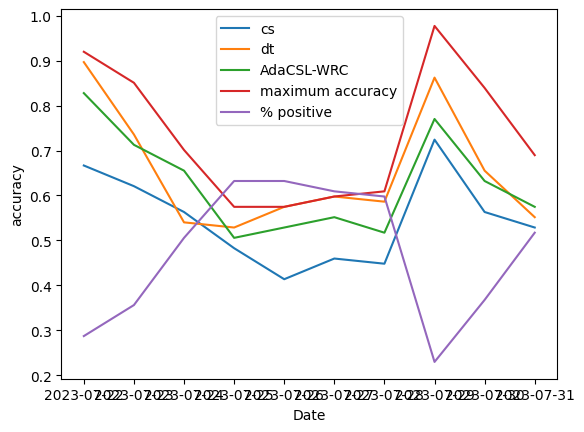

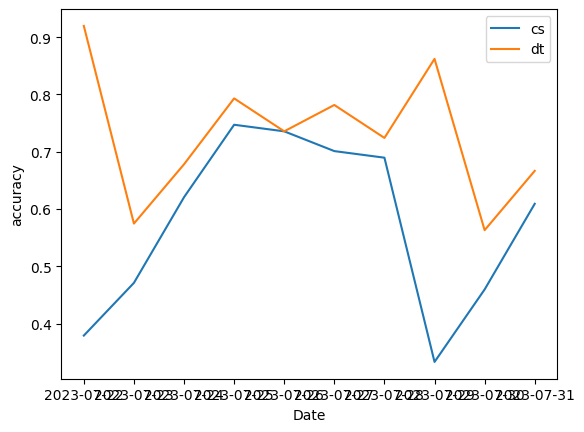

Constraint: 38.0 / 0.44 in precent 


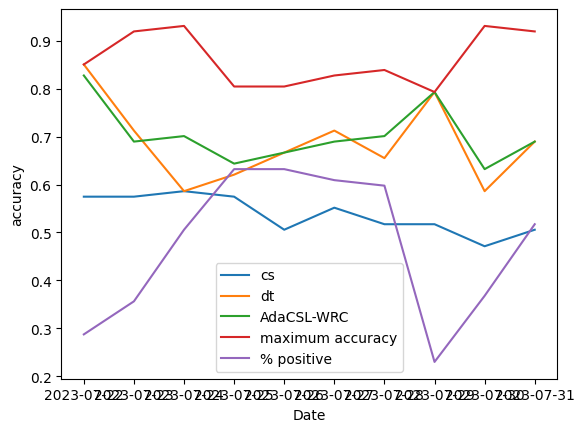

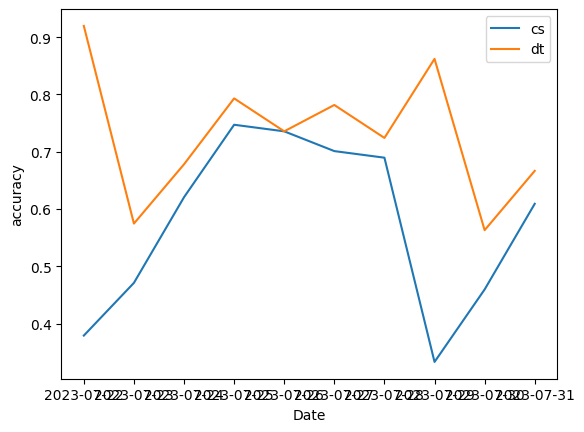

a12f6956-9aca-4550-8caa-2e2f9532674c
Number of instances: 29.0
Constraint: 2.0 / 0.07 in precent 


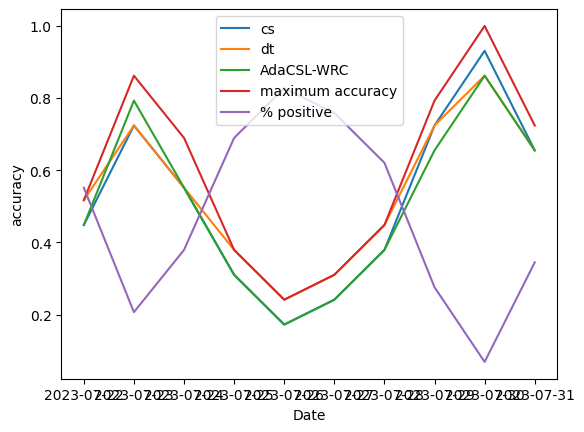

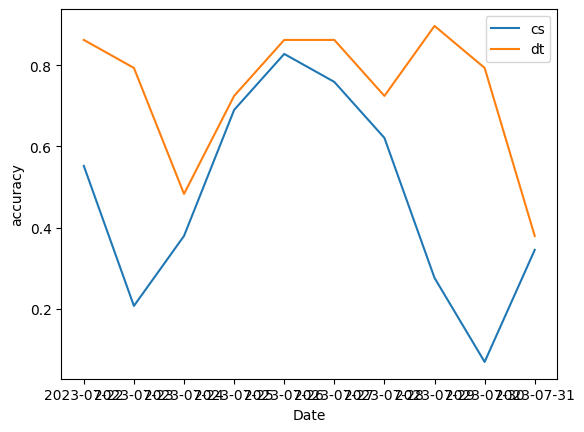

Constraint: 17.0 / 0.59 in precent 


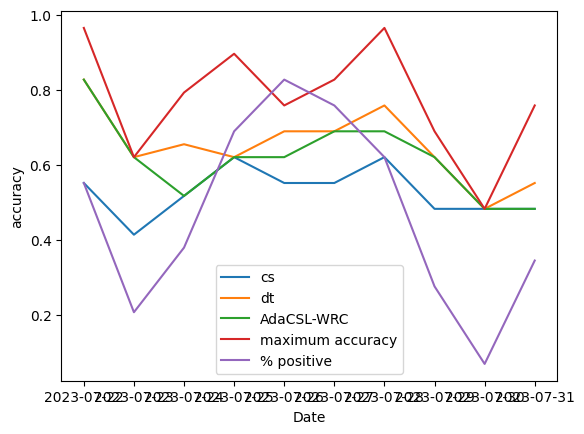

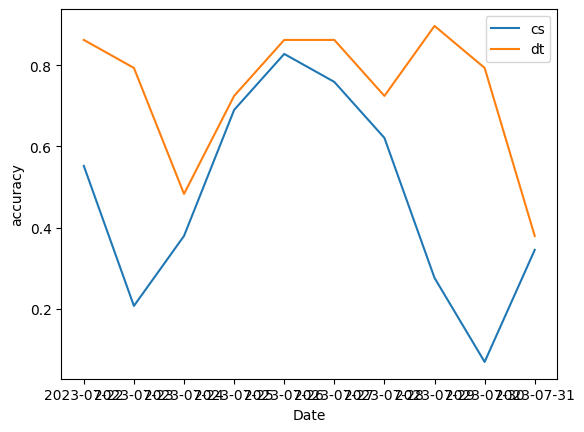

02531004-4599-4177-9d7d-00bc85a200c6
Number of instances: 28.0
Constraint: 8.0 / 0.29 in precent 


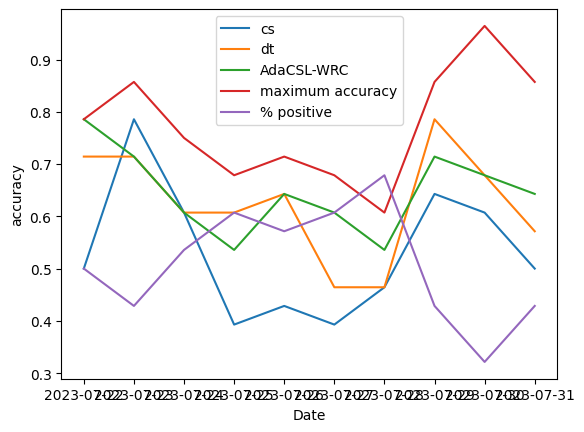

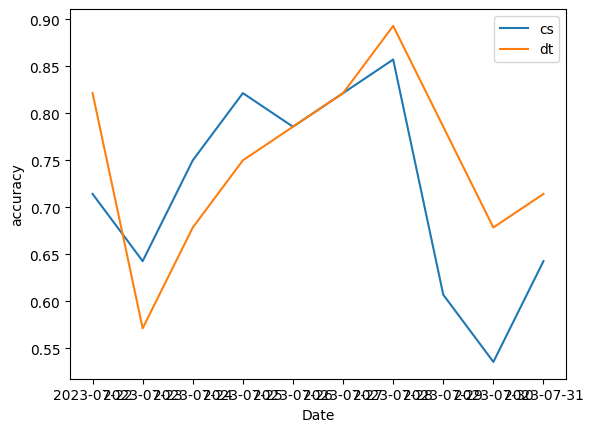

Constraint: 13.0 / 0.46 in precent 


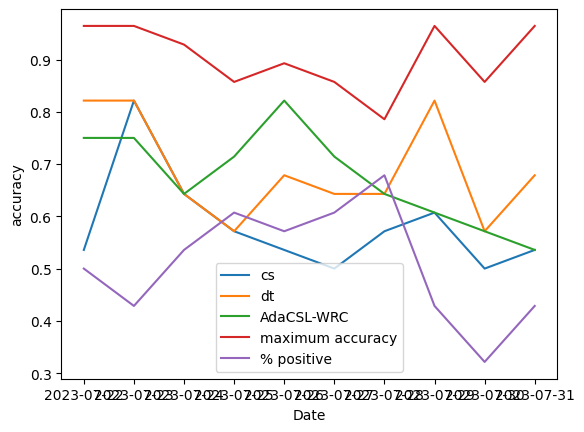

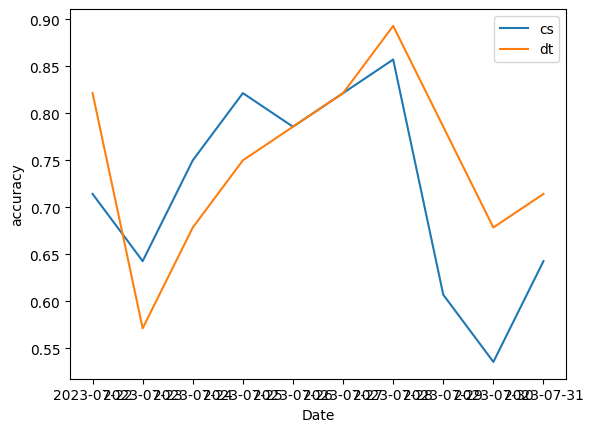

856f211d-c66e-4db7-b910-7419900a70e1
Number of instances: 23.0
Constraint: 5.0 / 0.22 in precent 


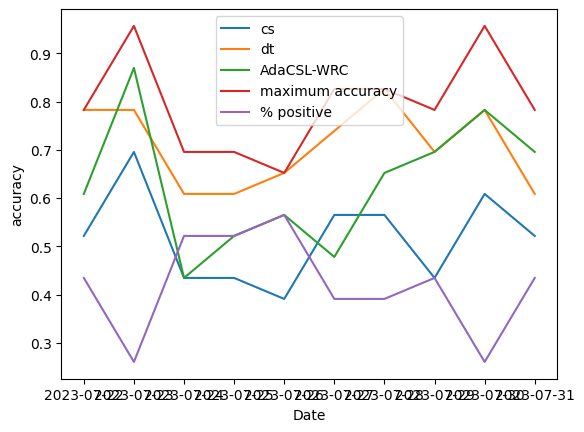

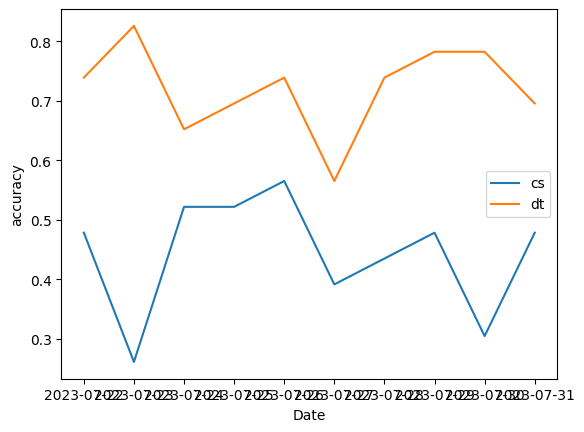

Constraint: 9.0 / 0.39 in precent 


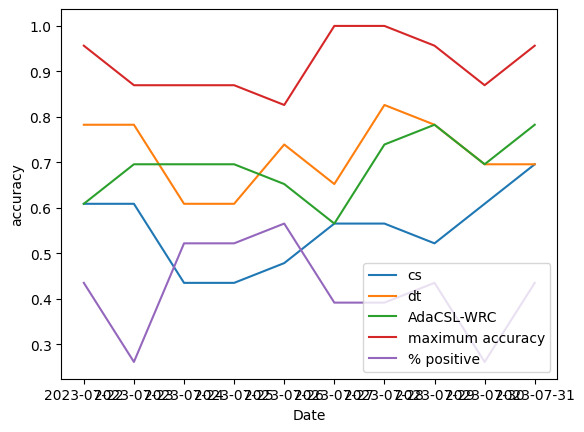

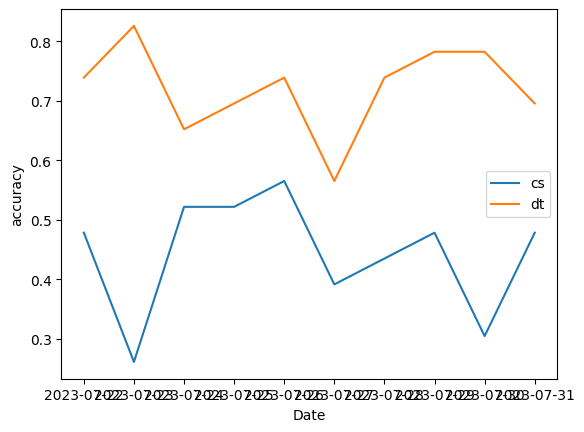

In [21]:
for provider in providers_list:
    cs_dict = provider_dict[provider]['cs_dict']
    dt_dict = provider_dict[provider]['dt_dict']    
    constraints_list = provider_dict[provider]['constraints_list']
    n_cred = provider_dict[provider]['n_cred']
    groupby_df = provider_dict[provider]['groupby_df']
    print(provider)
    print(f'Number of instances: {n_cred}')
    for i, constraint in enumerate(constraints_list):
        print(f'Constraint: {constraint} / {constraint/n_cred:.2f} in precent ')
        plot_results_metric(cs_dict, dt_dict, constraint, 'accuracy', test_dates, groupby_df[f'max_acc_constraint_{i}'], groupby_df['%positive'], is_constrained=True)
        plot_results_metric(cs_dict, dt_dict, constraint, 'accuracy', test_dates, groupby_df[f'max_acc_constraint_{i}'], groupby_df['%positive'], is_constrained=False)

In [22]:
cs_list, dt_list, ada_list = [], [], []
for provider in providers_list:
    cs_dict = provider_dict[provider]['cs_dict']
    dt_dict = provider_dict[provider]['dt_dict']
    constraints_list = provider_dict[provider]['constraints_list']
    
    constrained = 'constrained'
    for constraint in constraints_list:
        cs_metric, dt_metric, adacs_metric = [], [], []
        for date in test_dates:
            cs_result = cs_dict[date][constraint]['results_dict']
            adacs_metric.append([cs_result[k][constrained]['accuracy'] for k in cs_result.keys()][-1])
            cs_metric.append([cs_result[k][constrained]['accuracy'] for k in cs_result.keys()][0])
            dt_metric.append(dt_dict[date][constraint]['results_dict'][constrained]['accuracy'])
        cs_list.append([adacs_metric[k] - cs_metric[k] for k in range(len(test_dates))])
        dt_list.append([adacs_metric[k] - dt_metric[k] for k in range(len(test_dates))])

In [23]:
cs_improve = np.mean(cs_list, axis=0)
dt_improve = np.mean(dt_list, axis=0)

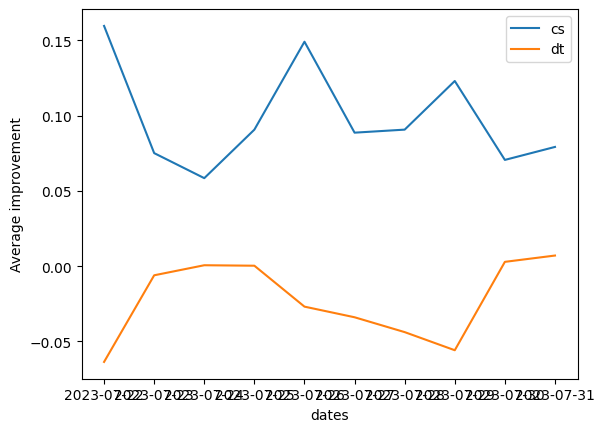

In [24]:
plt.plot(test_dates, cs_improve, label='cs')
plt.plot(test_dates, dt_improve, label='dt')
plt.xlabel('dates')
plt.ylabel('Average improvement')
plt.legend()
plt.show()

In [31]:
test_dates

array(['2023-07-22', '2023-07-23', '2023-07-24', '2023-07-25',
       '2023-07-26', '2023-07-27', '2023-07-28', '2023-07-29',
       '2023-07-30', '2023-07-31'], dtype=object)

In [28]:
cs_dict = provider_dict[providers_list[1]]['cs_dict']
dt_dict = provider_dict[providers_list[1]]['dt_dict']    
constraints_list = provider_dict[providers_list[1]]['constraints_list']
n_cred = provider_dict[providers_list[1]]['n_cred']
groupby_df = provider_dict[providers_list[1]]['groupby_df']
constraint = constraints_list[0]

In [46]:
mask_test_provider = df_with_provider['provider_id'] == providers_list[1]
model_cs = CostSensitiveDecisionTreeClassifier() #The base object, we will train it.
model_cs.set_params(**cs_best_params)
for i, date in enumerate(test_dates):
    print(date)
    mask_train_dates = df['prediction_date'].isin(df['prediction_date'].unique()[i:-10+i])
    mask_test_date = df['prediction_date'] == date
    X_train = df[mask_train_dates].drop(labels=['credentialset_id', 'prediction_date', 'target'], axis=1)
    X_test = df[mask_test_provider & mask_test_date].drop(labels=['credentialset_id', 'prediction_date', 'target'], axis=1)
    y_train = df[mask_train_dates]['target']
    y_test = df[mask_test_date & mask_test_provider]['target']
    print('AdaCSL-WRC')
    model_ada = cs_dict[date][constraint]['best_model_']
    y_pred_proba = model_ada.predict_proba(X_test.to_numpy())[:, 1]
    D={} # dictionary to count the number of instances for each probability
    for val in y_pred_proba:
        D[val] = D.get(val,0) +1
    print(D)
    print('CS')
    model_cs.fit(X_train.to_numpy(), y_train.to_numpy(), cost_mat = prepare_for_cost_cle(len(X_train), COST_MATRIX)) 
    y_pred_proba = model_cs.predict_proba(X_test.to_numpy())[:, 1]
    D={} # dictionary to count the number of instances for each probability
    for val in y_pred_proba:
        D[val] = D.get(val,0) +1
    print(D)
    print('DT')
    model_dt =  dt_dict[date][constraint]['best_model_']
    y_pred_proba = model_dt.predict_proba(X_test)[:, 1]
    D={} # dictionary to count the number of instances for each probability
    for val in y_pred_proba:
        D[val] = D.get(val,0) +1
    print(D)

2023-07-22
AdaCSL-WRC
{0.3030917874396135: 23, 0.4939467312348668: 4, 0.6746987951807228: 2}
CS
{0.5135840613679948: 29}
DT
{0.34369542438002093: 1, 0.6674618320610687: 8, 0.8912308092635961: 8, 0.08983218163869694: 10, 0.15569272976680384: 2}
2023-07-23
AdaCSL-WRC
{0.28687252890245735: 22, 0.150997150997151: 3, 0.5675675675675675: 3, 0.8666666666666667: 1}
CS
{0.5087039592399958: 29}
DT
{0.11440443213296399: 1, 0.08882783882783883: 14, 0.8910323253388946: 8, 0.3918799646954987: 1, 0.6635160680529301: 4, 0.17410323709536307: 1}
2023-07-24
AdaCSL-WRC
{0.30065075921908896: 29}
CS
{0.5067112313650591: 29}
DT
{0.152233676975945: 1, 0.6624173748819642: 4, 0.8870840974587372: 9, 0.6182926829268293: 13, 0.05026677899466442: 1, 0.34288710241174414: 1}
2023-07-25
AdaCSL-WRC
{0.3328995198133106: 29}
CS
{0.50713262979265: 29}
DT
{0.11339062933185473: 1, 0.6557701832590391: 5, 0.6263048016701461: 12, 0.883405778573255: 9, 0.3915929203539823: 2}
2023-07-26
AdaCSL-WRC
{0.3135366254757318: 29}
CS
{0.

In [35]:
constraint_percent = constraint/len(y_test)
model = cs_dict['2023-07-31'][constraint]['best_model_']
y_pred_proba = model.predict_proba(X_test.to_numpy())[:, 1]
y_pred_constrained = prediction_up_to_constraint(y_pred_proba, constraint_percent)

In [38]:
D={} # dictionary to count the number of instances for each probability
for val in y_pred_proba:
    D[val] = D.get(val,0) +1
print(D)

{0.2972777991535206: 28, 0.88844779674474: 1}


In [161]:
cs_dict = provider_dict[providers_list[1]]['cs_dict']
dt_dict = provider_dict[providers_list[1]]['dt_dict']
constraints_list = provider_dict[providers_list[1]]['constraints_list']
n_cred = provider_dict[providers_list[1]]['n_cred']
groupby_df = provider_dict[providers_list[1]]['groupby_df']

In [44]:
dt_dict['2023-07-22'][2.0]['best_model_']

DecisionTreeClassifier(max_depth=3, min_samples_leaf=20)